<a href="https://colab.research.google.com/github/virf96/Basico/blob/main/Algoritmos_de_Ensambles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensambles

## Preparación de ambiente

### Carga de módulos

In [1]:
import os 
import librosa # Librería para manejo de audio
import numpy as np
import pandas as pd
from scipy.io import wavfile # Manejo de
import IPython.display as ipd # Widget para Jupyter
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier # pip install xgboost
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier 

### Funciones relevantes

In [2]:
# Función que concentra cross validation para clasificación
def classification_metrics(X, y, estimator):
    ls_scores_roc = cross_val_score(estimator=estimator, X=X, y=y, scoring="accuracy", n_jobs=-1, cv=4)
    print(f"ROC media: {np.mean(ls_scores_roc):,.2f}, desviación estándar: {np.std(ls_scores_roc)}")

In [3]:
# Función que reproduce sonido en Jupyter
def wavPlayer(filepath):
    rate, data = wavfile.read(filepath)
    plt.plot(data)
    plt.show()
    return ipd.Audio(filepath, autoplay=True)

In [4]:
# Función para visualizar el mapa de calor de las frecuencias de sonido
def plot_heatmap(data):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
    plt.colorbar()

In [5]:
# Función que encapsula la lectura del alrchivo, el modelo y las variables para redecir el número
def predict_number(filepath, estimator, features):
    # Apertura del archivo
    x, sr = librosa.load(filepath, sr=None)
    # Generación de tabla para validación
    X_val = pd.DataFrame(np.reshape(abs(librosa.stft(x).mean(axis = 1).T), (1025,1))).T
    X_val.columns = X_train.columns
    real = int(filepath.split('/')[-1][0])
    # Predicción
    pred = int(estimator.predict(X_val)[0])
    print(f"The real is: {real}")
    print(f"The predicted is: {estimator.predict(X_val)[0]}")
    return wavPlayer(filepath=filepath)

## Carga de datos

### Lectura de archivos

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carga de archivos de sonido
file = os.listdir('./free-spoken-digit-dataset-master/recordings/')
data=[]
for i in file:
    x, sr = librosa.load('./free-spoken-digit-dataset-master/recordings/'+i, sr=None)
    data.append(x)

NameError: name 'os' is not defined

### Transformación

In [ ]:
# Aplicación de Transformada de Fourier a frecuencias de sonido
data_tf=[]
for i in range(len(data)):
    data_tf.append(abs(librosa.stft(data[i]).mean(axis = 1).T))
data_tf= np.array(data_tf)

In [ ]:
df = pd.DataFrame(data_tf)
df["target"] = [i[0] for i in file]

### EDA

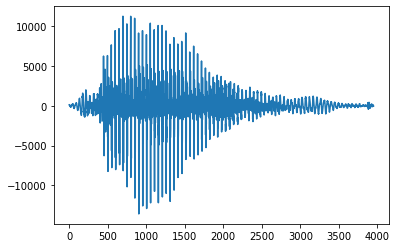

In [ ]:
# Visualización de frecuencias de sonido
wavPlayer("/home/oscar/Documentos/Oscar/Diplomado/Generación 3/Módulo 2/free-spoken-digit-dataset-master/recordings/9_george_4.wav")

In [ ]:
data_tf.shape

(2500, 1025)

In [ ]:
# Preparación de X y y
X = df[[x for x in df.columns if x != "target"]]
y = df["target"]

In [ ]:
y.value_counts()

3    250
2    250
4    250
5    250
8    250
7    250
0    250
9    250
6    250
1    250
Name: target, dtype: int64

### Separación de sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Modelado

### Bosque Aleatorio

#### Modelado

In [ ]:
RandomForestClassifier?

In [ ]:
bos = RandomForestClassifier(n_estimators=100, max_depth=5)

In [ ]:
bos.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Cross-validation

In [ ]:
classification_metrics(X=X_train, y=y_train, estimator=bos)

ROC media: 0.71, desviación estándar: 0.02135496251789809


#### Hyperparametrización

In [ ]:
param_dict = {"n_estimators": [x for x in range(100, 1500, 100)], # Número de árboles a construir
              "max_features": ["auto", "sqrt", "log2"], # Número máximo de variables a considerar
              "criterion": ["gini", "entropy"], # Criterio de selección de corte
              "class_weight": ["balanced", None], # Balanceo o no de la target
              "min_samples_split": [x for x in range(2, 50, 2)], # Número mínimo de muestras que debe tener una hoja para cortar
              "min_samples_leaf": [x/100 for x in range(5, 55, 5)]} # Número mínimo que debe tener una hoja

In [ ]:
# Búsqueda aleatorizada
search = RandomizedSearchCV(param_distributions=param_dict, cv=4, n_jobs=-1, scoring="accuracy", estimator=bos, verbose=5,n_iter=10)

In [ ]:
# WARNING! Este código demora mucho
search.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min


In [ ]:
search.best_estimator_

In [ ]:
search.best_score_

### AdaBoost

#### Modelado

In [ ]:
AdaBoostClassifier?

Object `AdaBoostClassifier` not found.


In [ ]:
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.05)

#### Cross-validation

In [ ]:
# Cross validation
classification_metrics(X=X_train, y=y_train, estimator=ada)

#### Hyperparametrización

In [ ]:
# Hiperparametrización
search_grid={'n_estimators':[50,100,200],
             'learning_rate':[.001,0.01,.1]}

In [ ]:
search = RandomizedSearchCV(param_distributions=search_grid, cv=4, n_jobs=-1, scoring="accuracy", estimator=ada, verbose=5,n_iter=9)

In [ ]:
# WARNING! Este código demora mucho
search.fit(X_train, y_train)

In [ ]:
search.best_estimator_

In [ ]:
search.best_score_

### Gradient Boosting

#### Modelado

In [ ]:
GradientBoostingClassifier?

In [ ]:
gb = GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=0.05)

#### Cross-validation

In [ ]:
classification_metrics(X=X_train, y=y_train, estimator=gb)

ROC media: 0.80, desviación estándar: 0.008292691479733919


### Voting

#### Modelado

In [ ]:
VotingClassifier?

In [ ]:
naiveb = GaussianNB()
logreg = LogisticRegression()
dctree = DecisionTreeClassifier()

#### Soft-voting

##### Cross-validation

In [ ]:
vc = VotingClassifier(estimators=[("logreg", logreg), ("arbol", dctree), ("bayes", naiveb)], voting='soft')

In [ ]:
classification_metrics(X=X_train, y=y_train, estimator=vc)

#### Hard-voting

##### Cross-validation

In [ ]:
vc = VotingClassifier(estimators=[("logreg", logreg), ("arbol", dctree), ("bayes", naiveb)], voting='hard')

In [ ]:
classification_metrics(X=X_train, y=y_train, estimator=vc)

### XGBoost

#### Modelado

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=190, max_depth=5, min_child_weight=2, objective="binary:logistic", subsample=0.9, colsample_bytree=0.8, seed=23333)

In [ ]:
xgb.fit(X_train, y_train)

#### Cross-validation

In [ ]:
classification_metrics(estimator=xgb, X = X_train, y=y_train)

In [ ]:
xgb.score(X_test, y_test)

### Análisis de resultados

In [ ]:
# Predicción del número de acuerdo con sus atributos
df["pred"] = xgb.predict(X)

In [ ]:
# Análisis de predicción por clases
confusion_matrix(y_true=df["target"], y_pred=df["pred"], labels=[x for x in map(str, range(10))])

In [ ]:
# Accuración por clase
for num in sorted(df["target"].unique()):
    print(num, accuracy_score(y_true=df.loc[df["target"] == num, "target"], y_pred=df.loc[df["target"] == num, "pred"]))

In [ ]:
# Accuracy global
accuracy_score(y_true=df["target"], y_pred=df["pred"])

### Validación con datos reales

In [ ]:
# Predicción con datos reales usando la función del principio
predict_number(filepath='/home/oscar/Documentos/Oscar/Diplomado/Generación 3/Módulo 2/free-spoken-digit-dataset-master/acquire_data/recordings/9_oscar_0.wav', estimator=xgb, features=X_train.columns)